# NLP as a tool for  Mental Health Classification.
by Eric J. Chan

Date: 1 May 2023

dataset:
https://www.kaggle.com/datasets/reihanenamdari/mental-health-corpus


In [1]:
## Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from scipy import stats
# Cause plots to be displayed in the notebook:
%pylab inline
%matplotlib inline

import string
import spacy
import gensim
from wordcloud import WordCloud
from collections import Counter

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split



import re

Populating the interactive namespace from numpy and matplotlib


2023-04-29 19:39:54.393090: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

## Helper Functions

In [9]:
#define helper function for ploting word counts  
def plot_bar_word_count(df):
    ax=sns.barplot(data=df,x=df.index.values,y='count',palette="viridis",edgecolor='k')
    ax=plt.xticks(rotation = 90)
    ax=plt.xlabel('')   

In [10]:
#define helper function for ploting  wordcloud plot
def plot_word_cloud(df):
    wordcloud = WordCloud(width=800, height=800, background_color='white',colormap=sns.color_palette("cubehelix", as_cmap=True)).generate_from_frequencies(df['count'].to_dict())
    plt.figure(figsize=[8,8])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

In [11]:
# define helper function for subarray plot
# this takes in one document row in wide form  
def multi_plot_bar_word_count(df, max_words=15,rows=2,cols=3 ):
    fig, axes = plt.subplots(rows, cols, figsize=(10,6))
    k=0
    for i in range(rows): 
        for j in range(cols):
            dum=pd.DataFrame(df.iloc[k].T.sort_values(ascending=False))
            dum.columns=['count']
            sns.barplot(ax=axes[i,j],data=dum.head(max_words),x=dum.head(max_words).index.values,y='count',palette="viridis",edgecolor='k')
            axes[i, j].set_xticklabels(dum.head(max_words).index.values, rotation=90)
            k+=1
        

In [12]:
# define helper function for subarray plot
# this takes in one document row in wide form  
def multi_plot_word_cloud(df, max_words=20,rows=2,cols=3 ):
    fig, axes = plt.subplots(rows, cols, figsize=(10,6))
    k=0
    for i in range(rows): 
        for j in range(cols):
            # print(df_test.iloc[k])
            dum=pd.DataFrame(df.iloc[k].T.sort_values(ascending=False))
            dum.columns=['count']
            wordcloud = WordCloud(width=800, height=800, background_color='white',
                                  colormap=sns.color_palette("cubehelix", as_cmap=True)).generate_from_frequencies(dum.head(max_words)['count'].to_dict())

            axes[i, j].imshow(wordcloud, interpolation='bilinear')
            axes[i, j].axis("off")
            k+=1

In [13]:
def plot_wordcloud_for_topic(topic_id, lda_components, feature_names, max_words=20):
    # Get the topic's word distribution
    topic_word_dist = lda_components[topic_id]

    # Sort the indices of the word distribution in descending order of probability
    sorted_word_dist_indices = topic_word_dist.argsort()[::-1]  # the [::-1] is a slice trik to reverse an array

    # Get the top words and their probabilities for the topic
    top_words = [feature_names[i] for i in sorted_word_dist_indices[:max_words]]
    top_word_probs = [topic_word_dist[i] for i in sorted_word_dist_indices[:max_words]]

    # Create a dictionary of word-probability pairs
    word_probs = dict(zip(top_words, top_word_probs))

    # Create a word cloud using the dictionary of word-probability pairs
    wc = WordCloud(background_color='white', max_words=max_words)
    wc.generate_from_frequencies(word_probs)

    # Plot the word cloud
    plt.figure(figsize=(10, 8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [16]:
def multiplot_wordcloud_for_topics( topic_list,  lda_components, feature_names, rows=2, cols=2, max_words=20):
    fig, axes = plt.subplots(rows, cols, figsize=(10,6))
    k=0
    for i in range(rows): 
        for j in range(cols):
            topic_id=topic_list[k]
            # Get the topic's word distribution
            topic_word_dist = lda_components[topic_id]

            # Sort the indices of the word distribution in descending order of probability
            sorted_word_dist_indices = topic_word_dist.argsort()[::-1]  # the [::-1] is a slice trik to reverse an array

            # Get the top words and their probabilities for the topic
            top_words = [feature_names[i] for i in sorted_word_dist_indices[:max_words]]
            top_word_probs = [topic_word_dist[i] for i in sorted_word_dist_indices[:max_words]]

            # Create a dictionary of word-probability pairs
            word_probs = dict(zip(top_words, top_word_probs))

            # Create a word cloud using the dictionary of word-probability pairs
            wc = WordCloud(background_color='white', max_words=max_words)
            wc.generate_from_frequencies(word_probs)

            # Plot the word cloud
   
            axes[i,j].imshow(wc, interpolation='bilinear')
            axes[i,j].axis('off')
            axes[i,j].set_title('Topic: %d'%topic_id)
            k+=1


## Read data and begin processing

In [210]:
import pandas as pd
import spacy
import gensim

# Load the mental_health.csv data into a pandas dataframe
df = pd.read_csv('mental_health.csv')

# Preprocess the text data using spaCy
nlp = spacy.load('en_core_web_lg')

In [20]:
df.head()

text  label
0  dear american teens question dutch person hear...      0
1  nothing look forward lifei dont many reasons k...      1
2  music recommendations im looking expand playli...      0
3  im done trying feel betterthe reason im still ...      1
4  worried  year old girl subject domestic physic...      1

In [211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27977 entries, 0 to 27976
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    27977 non-null  object
 1   label   27977 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 437.3+ KB


In [21]:
df['label'].isnull().sum()

0

### more helper functions

In [22]:
def convert_text(text):
    '''
    Use techniques learned in previous labs. Remove StopWords, Punctuation, Lemmatize, lowercase etc.
    '''
    doc = nlp(text) # this is slow but nessesary for stopwords and lemmatizing
    # convert all tokens to lowercase
    # doc_lower = [token.lower_ for token in doc]
  
    # Removes StopWords, Punctuation and Lemmatize inline 
    text=' '.join(['' if (t.is_stop |  t.is_punct )else t.lemma_.lower() for t in doc]) 
    
    text = re.sub(r'\n', ' ', text)  # remove newline
    text = re.sub(r'\s+', ' ', text)  # clean up spacing
    
    return text

In [23]:
def remove_small_words(text,max_chars=2):
    text = re.sub(r'\b\w{1,%i}\b'%max_chars, '', text)  # remove newline
    return text

#### Data cleanse 

In [33]:
df_clean=pd.read_csv('mental_heath_EJC_cleaned.csv')

In [52]:
df_bw=pd.read_csv('mental_heath_EJC_big_words.csv')
df_bw=df_bw.dropna() # remove rows with null values
df_bw.isnull().value_counts()

Unnamed: 0  text   label
False       False  False    27975
dtype: int64

In [212]:
df_bw['label'].value_counts()

0    14138
1    13837
Name: label, dtype: int64

#### Separate documents  into the two categories for some Visual EDA

In [53]:
df_notdep_old=df_clean[df_clean['label']==0].copy()
df_isdep_old=df_clean[df_clean['label']==1].copy()

In [54]:
df_notdep=df_bw[df_bw['label']==0].copy()
df_isdep=df_bw[df_bw['label']==1].copy()

## Prelim EDA 
Use the count vectorizer to get some idea of small word freqs. 
If  they appear useless - remove for the time being and can put back in later  

In [31]:
max_chars=2
# Create a CountVectorizer instance with token pattern for 5-character words
cv = CountVectorizer(token_pattern=r'\b\w{1,%i}\b'%max_chars)

# Fit and transform the documents using the CountVectorizer
dum = cv.fit_transform(df_clean['text'].head(100))

# Get the vocabulary of the CountVectorizer
vocab = cv.get_feature_names_out()

# Print the vocabulary of 5-character words
print(vocab)

['bc' 'bf' 'bi' 'br' 'd' 'de' 'dm' 'em' 'ex' 'f' 'go' 'gt' 'hr' 'ii' 'k'
 'km' 'la' 'm' 'mg' 'ms' 'n' 'nd' 'od' 'oh' 'ok' 'op' 'rd' 'rn' 's' 'to'
 'tv' 'u' 'uh' 'uk' 'ur' 've' 'w' 'ya' 'yo']


#### plot word counts and cloud for tokens with  two or less chars 

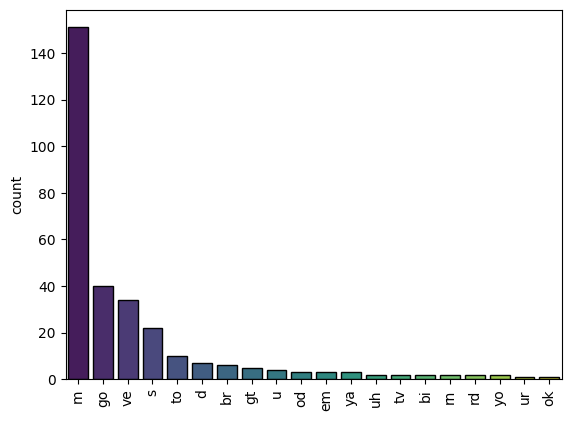

In [32]:
# manage data for ploting
dum_dtm=pd.DataFrame( dum.toarray(),columns= [w for w in cv.get_feature_names_out()])
dum_long=pd.DataFrame(dum_dtm.T.sum(axis=1).sort_values(ascending=False),columns=['count'])
max_words=20
plot_bar_word_count(dum_long.head(max_words))

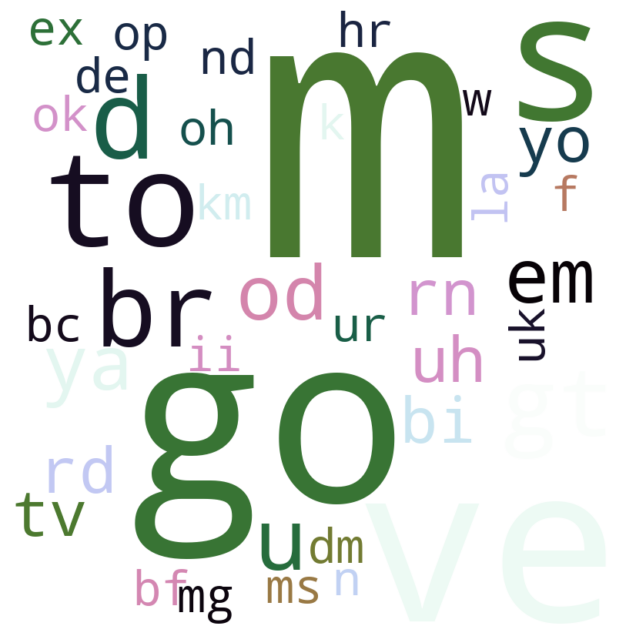

In [287]:
plot_word_cloud(dum_long.head(50))

# EDA
Cosine similary matirx using 300-Dimension word vectors from the spacy lg model

In [25]:
# helper function
def cosine_similarity_matrix(df1,df2):
    cosine_similarity_matrix=np.zeros((len(df1),len(df2)))
    for i in range(len(df1)):
        for j in range(len(df2)):
            doc1 = nlp(df1['text'].iloc[i])
            doc2 = nlp(df2['text'].iloc[j])

# compute the cosine similarity between the documents
# for a doc  of words it is using the mean of all the word vectors 
            cosine_similarity_matrix[i,j] = doc1.similarity(doc2)

    return cosine_similarity_matrix
             
# print the cosine similarity between the two documents

In [296]:
# define two example corpus
# Note: the token vector generated in spacy is closer to a glove vector 

maxdoc=100
csm1=cosine_similarity_matrix(df_notdep.head(maxdoc),df_notdep.head(maxdoc))
csm2=cosine_similarity_matrix(df_notdep.head(maxdoc),df_isdep.head(maxdoc))
csm3=cosine_similarity_matrix(df_isdep.head(maxdoc),df_isdep.head(maxdoc))



0.6629430080630958

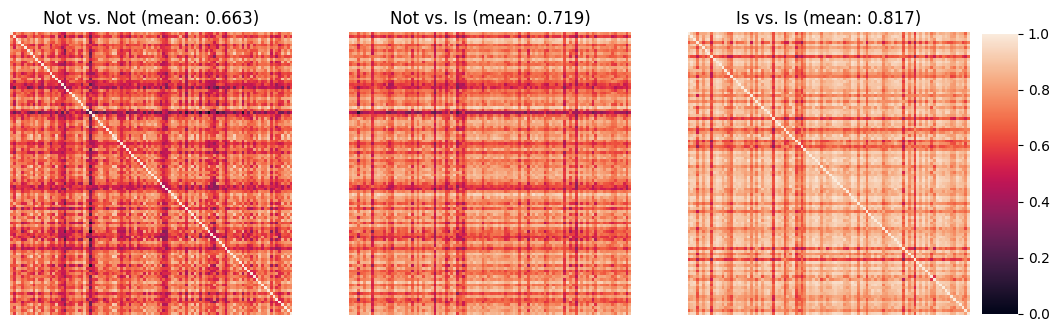

In [299]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))
cbar_ax = fig.add_axes([.91, 0.15, 0.03, 0.7])
sns.heatmap(ax=axes[0], data=csm1,robust=True, cbar=False,square=True, vmin=0.0, vmax=1.0)
sns.heatmap(ax=axes[1], data=csm2,robust=True, cbar=False,square=True, vmin=0.0, vmax=1.0)
sns.heatmap(ax=axes[2], data=csm3,robust=True, cbar_ax=cbar_ax,square=True, vmin=0.0, vmax=1.0)
axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")
axes[0].set_title('Not vs. Not (mean: %.3f)'%np.mean(csm1))
axes[1].set_title('Not vs. Is (mean: %.3f)'%np.mean(csm2))
axes[2].set_title('Is vs. Is (mean: %.3f)'%np.mean(csm3))
# 
#fig.colorbar()
# sns.colorbar(ax=cbar_ax)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.2)


(optional if time) condensed clustermap of the 300 dimensional vectors - might take a while  

### generate  document vectors for fitting and save as .json

In [ ]:
import json
# Load the data from JSON file
#  run this after saved  
with open('gloveX_big.json', 'r') as f:
    dum_data = json.load(f)

# Convert the list back to a NumPy array
gloveX = np.array(dum_data)

In [57]:
np.shape(gloveX)

(27975, 300)

/Users/echanj/.local/share/virtualenvs/jupyter_stuff-JQ3hnF7h/lib/python3.7/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


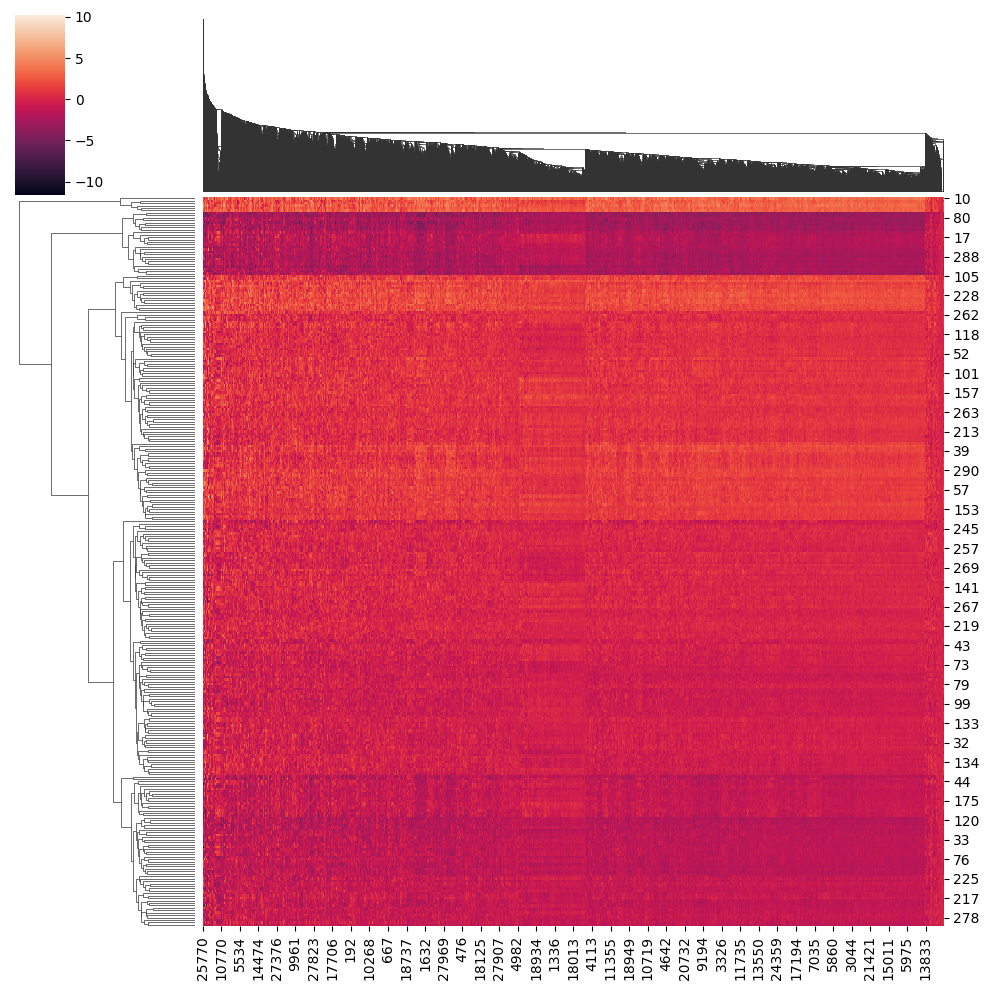

In [202]:
sns.clustermap(np.transpose(gloveX),row_cluster=True,col_cluster=True)

### Doing some EDA using the full dataset 

In [60]:
## ANSWER
## split the dataset
# Features and Labels
X = df_bw['text']
y = df_bw['label']

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
Xg_train, Xg_test, y_train, y_test = train_test_split(gloveX, y, test_size = 0.2, random_state = 42)

## More Feature Engineering

In [61]:
# create a count vectorizer object
count_vect = CountVectorizer(token_pattern = r'\w{1,}')

# Learn a vocabulary dictionary of all tokens in the raw documents
count_vect.fit(X)

# Transform documents to document-term matrix.
X_count = count_vect.transform(X)
X_train_count = count_vect.transform(X_train)
X_test_count = count_vect.transform(X_test)

### Count Vectors as features

In [62]:
# this gives the size of the count vector 
print(np.shape(X_count.toarray()))
print(np.sum(X_count))


(27975, 63070)
1518167


### lets do some EDA on our count vectors

In [63]:
df_dtm=pd.DataFrame( X_count.toarray(),columns= [w for w in count_vect.get_feature_names_out()])

In [64]:
df_long=pd.DataFrame(df_dtm.T.sum(axis=1).sort_values(ascending=False),columns=['count'])
print(df_long.sum())
df_long.head()

count    1518167
dtype: int64


count
not   24795
like  23255
feel  21204
want  21155
know  18540

### plots over the corpus 

In [71]:
#define helper function for ploting word counts  
def plot_bar_word_count(df):
    plt.figure(figsize=[15,8])
    ax=sns.barplot(data=df,x=df.index.values,y='count',palette="viridis",edgecolor='k')
    ax=plt.xticks(rotation = 90)
    ax=plt.xlabel('')   

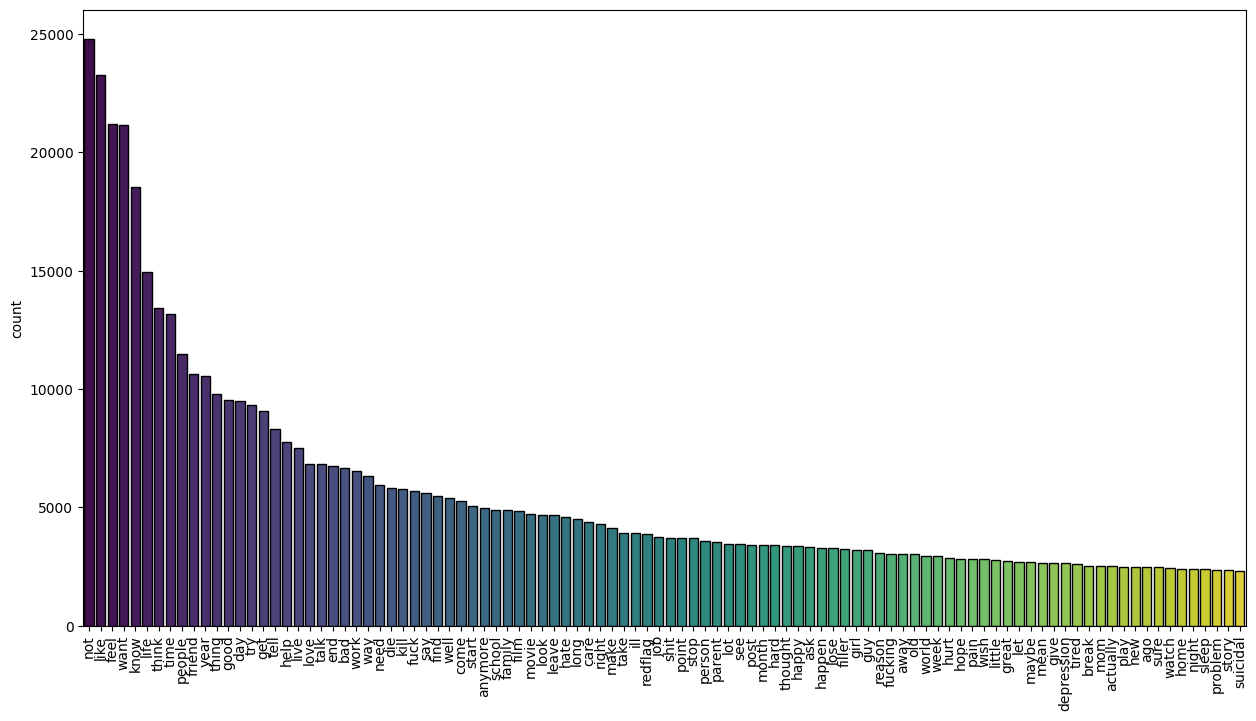

In [72]:
max_words=100
plot_bar_word_count(df_long.head(max_words))

## In future when working with words in a bar plot its better to use a horizontal barplot 

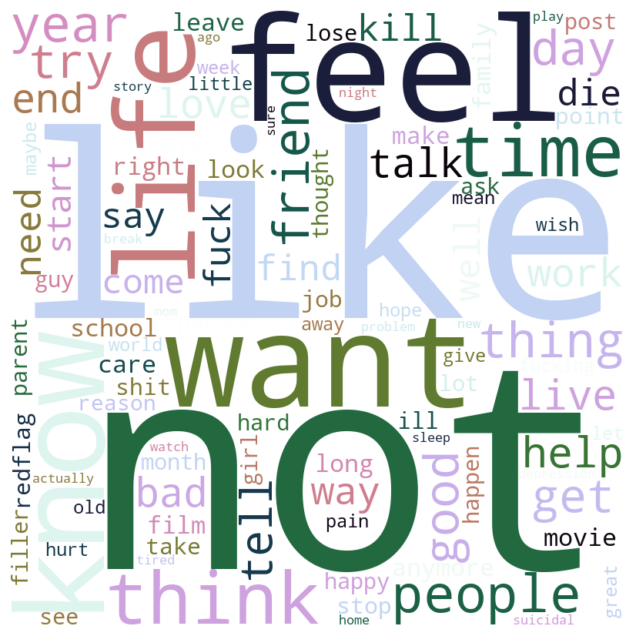

In [73]:
plot_word_cloud(df_long.head(100))

# Some individual plots for each document 

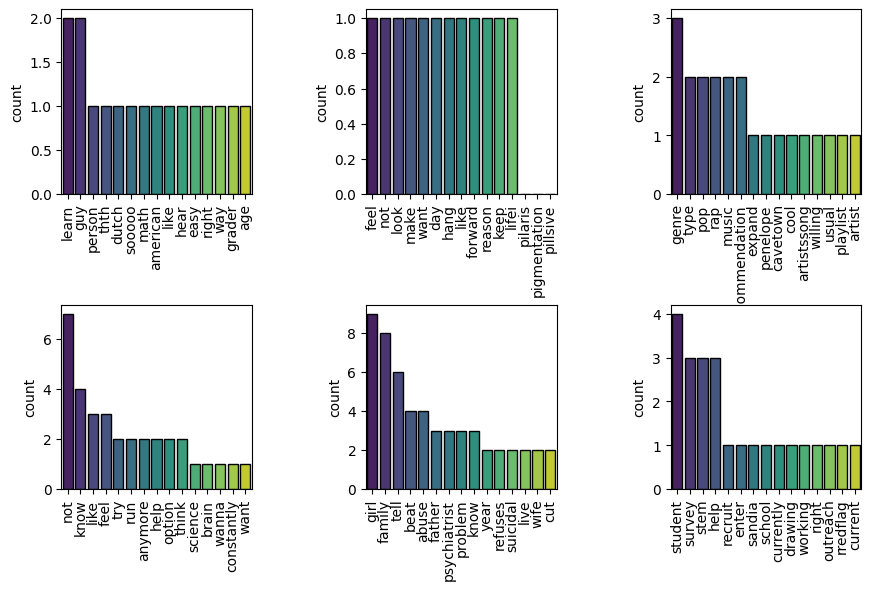

In [74]:
multi_plot_bar_word_count(df_dtm)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.6,
                    hspace=0.6)
    
    

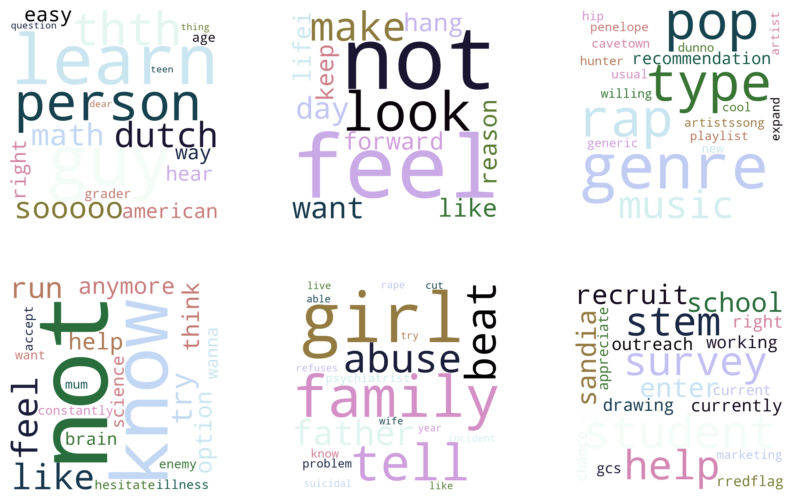

In [75]:
multi_plot_word_cloud(df_dtm)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.3)
    
    

# Now do EDA on manually seperated datasets

In [76]:
# workup for eda on seperate arrays
# declare data
X_not=df_notdep['text']
X_is=df_isdep['text']

# fit
count_vect_not = CountVectorizer(token_pattern = r'\w{1,}')
count_vect_is = CountVectorizer(token_pattern = r'\w{1,}')
count_vect_not.fit(X_not)
count_vect_is.fit(X_is)

# Transform documents to document-term matrix.
X_count_not = count_vect_not.transform(X_not)
X_count_is = count_vect_is.transform(X_is)

# manage data for ploting
df_dtm_not=pd.DataFrame( X_count_not.toarray(),columns= [w for w in count_vect_not.get_feature_names_out()])
df_long_not=pd.DataFrame(df_dtm_not.T.sum(axis=1).sort_values(ascending=False),columns=['count']) 

df_dtm_is=pd.DataFrame( X_count_is.toarray(),columns= [w for w in count_vect_is.get_feature_names_out()])
df_long_is=pd.DataFrame(df_dtm_is.T.sum(axis=1).sort_values(ascending=False),columns=['count']) 

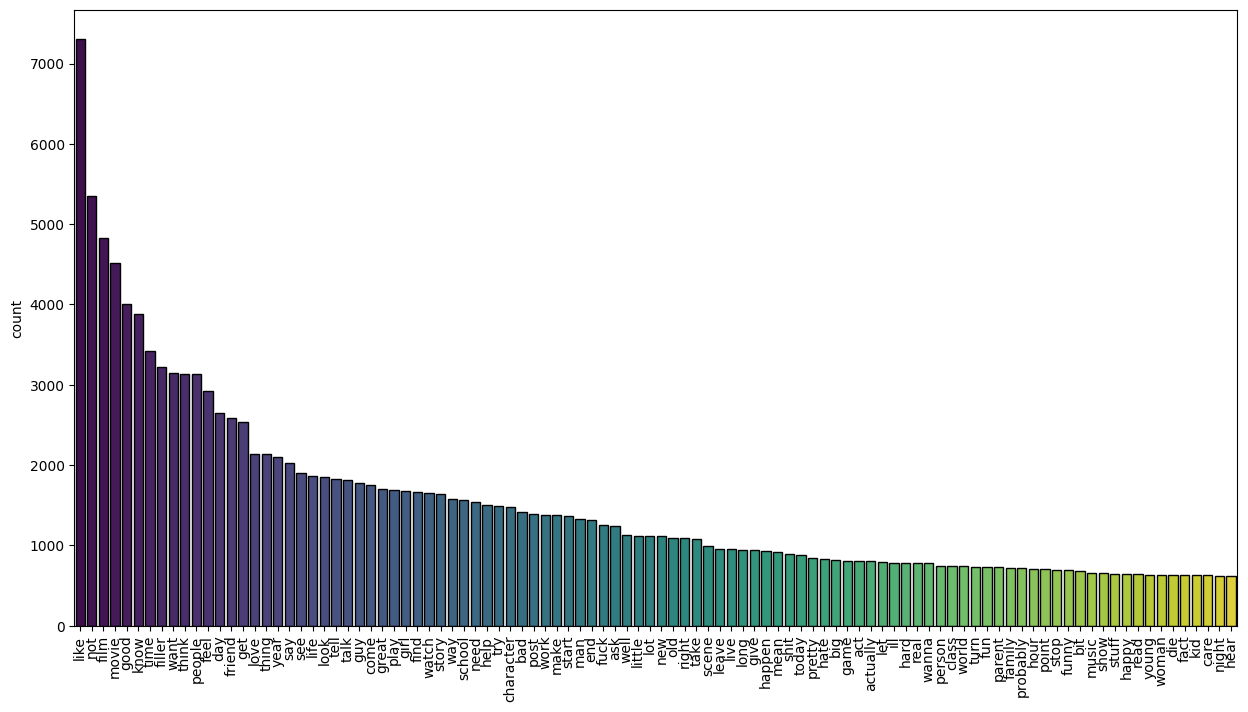

In [77]:
max_words=100
plot_bar_word_count(df_long_not.head(max_words))

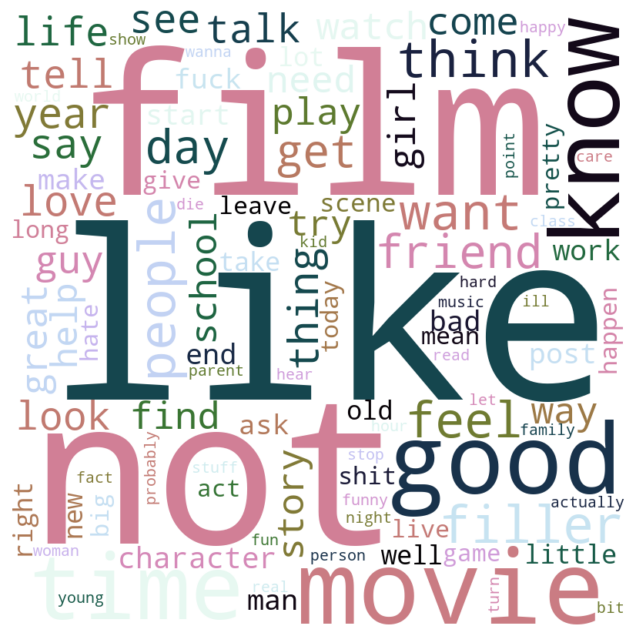

In [78]:
plot_word_cloud(df_long_not.head(100))

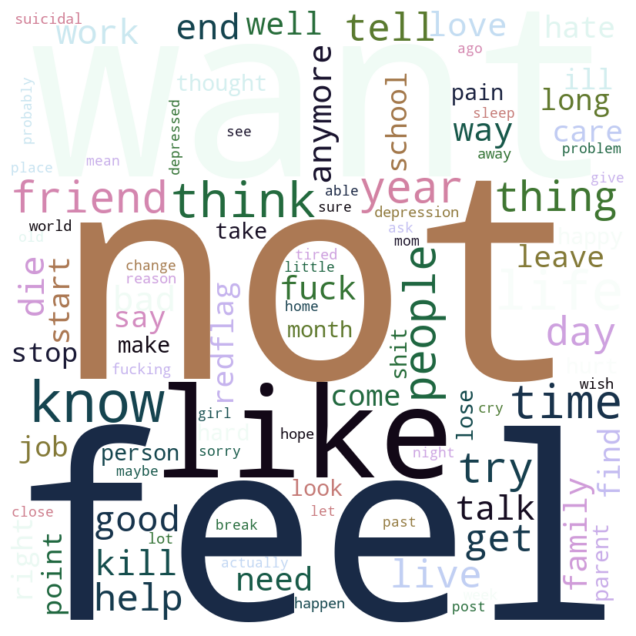

In [80]:
plot_word_cloud(df_long_is.head(100))

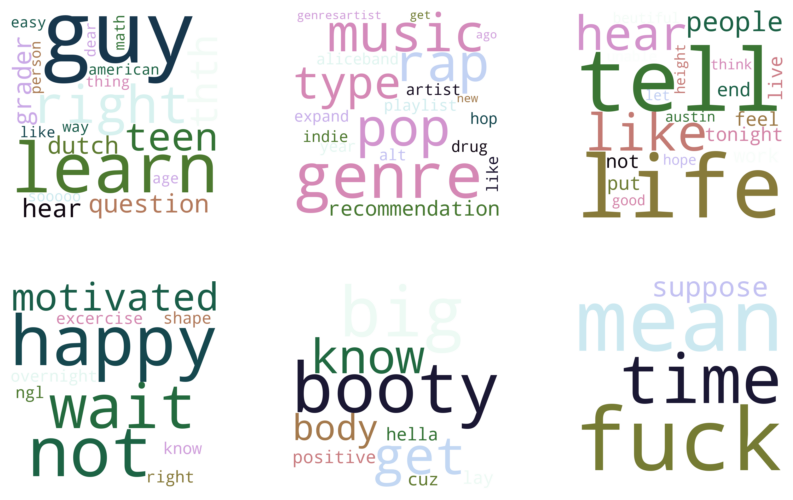

In [79]:
multi_plot_word_cloud(df_dtm_not)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.3)

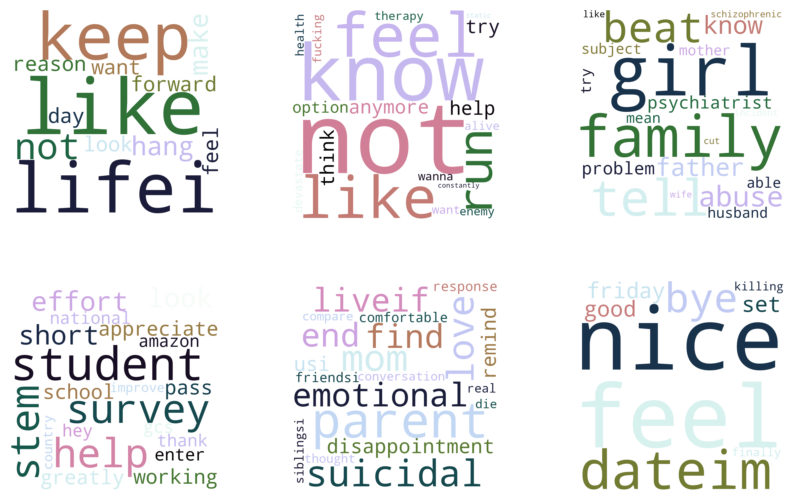

In [43]:
multi_plot_word_cloud(df_dtm_is)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.3)

## this is 2-gram - might use this later 

In [81]:
count_vect2 = CountVectorizer(analyzer='word', ngram_range=(2, 2),token_pattern = r'\w{1,}')
count_vect2.fit(X)
X_train_count2 = count_vect2.transform(X_train)
X_test_count2 = count_vect2.transform(X_test)

In [82]:
print(X_train_count2[:2])
print(np.shape(X_train_count2))
np.sum(X_train_count.toarray()[:2],axis=1)
count_vect2.get_feature_names_out()

  (0, 368084)	1
  (0, 464827)	1
  (0, 525315)	1
  (0, 623081)	1
  (1, 30095)	1
  (1, 116214)	1
  (1, 140767)	1
  (1, 171021)	1
  (1, 240339)	1
  (1, 296016)	1
  (1, 297261)	1
  (1, 351608)	1
  (1, 384500)	1
  (1, 406870)	1
  (1, 420752)	1
  (1, 511873)	1
  (1, 512148)	1
  (1, 564017)	1
  (1, 653828)	1
  (1, 671717)	1
  (1, 694645)	1
  (1, 714748)	1
  (1, 717598)	1
(22380, 769229)


array(['aaa booklet', 'aaa hornier', 'aaa sound', ..., 'zyprexa help',
       'zzuckerberg sorry', 'zzzz thing'], dtype=object)

### TF-IDF Vectors as features
- Word level
- N-Gram level
- Character level

In [83]:
%%time
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer = 'word',
                             token_pattern = r'\w{1,}',
                             max_features = 5000)
print(tfidf_vect)

tfidf_vect.fit(X)
X_train_tfidf = tfidf_vect.transform(X_train)
X_test_tfidf  = tfidf_vect.transform(X_test)
print(np.shape(X_train_tfidf))

TfidfVectorizer(max_features=5000, token_pattern='\\w{1,}')
(22380, 5000)
CPU times: user 1.96 s, sys: 35.4 ms, total: 2 s
Wall time: 2 s


In [84]:
%%time
# ngram level tf-idf
tfidf_vect_ngram = TfidfVectorizer(analyzer = 'word',
                                   token_pattern = r'\w{1,}',
                                   ngram_range = (2, 3),
                                   max_features = 5000)
print(tfidf_vect_ngram)

tfidf_vect_ngram.fit(X)
X_train_tfidf_ngram = tfidf_vect_ngram.transform(X_train)
X_test_tfidf_ngram  = tfidf_vect_ngram.transform(X_test)

TfidfVectorizer(max_features=5000, ngram_range=(2, 3), token_pattern='\\w{1,}')
CPU times: user 13.1 s, sys: 360 ms, total: 13.5 s
Wall time: 13.5 s


In [85]:
%%time
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer = 'char',
                                         ngram_range = (2, 3),
                                         max_features = 5000)
print(tfidf_vect_ngram_chars)

tfidf_vect_ngram_chars.fit(X)
X_train_tfidf_ngram_chars = tfidf_vect_ngram_chars.transform(X_train)
X_test_tfidf_ngram_chars  = tfidf_vect_ngram_chars.transform(X_test)

TfidfVectorizer(analyzer='char', max_features=5000, ngram_range=(2, 3))
CPU times: user 15 s, sys: 285 ms, total: 15.3 s
Wall time: 15.3 s


# Setup LDA models in both scikit learn and gensim and then do more EDA 

In [86]:
%%time
# train a LDA Model
# here we are training on count vectors which will be equivlent to tf. We could also have used tf-idf 
lda_model = LatentDirichletAllocation(n_components = 20, learning_method = 'online', max_iter = 20,random_state=42)

X_topics = lda_model.fit_transform(X_train_count)
topic_word = lda_model.components_ 
vocab = count_vect.get_feature_names_out()
X_test_lda = lda_model.transform(X_test_count)

CPU times: user 5min 36s, sys: 34.6 s, total: 6min 10s
Wall time: 3min 19s


In [87]:
print(np.shape(topic_word))
print(np.shape(X_topics))

(20, 63070)
(22380, 20)


In [88]:
# view the topic models
n_top_words = 10
topic_summaries = []
print('Group Top Words')
print('-----', '-'*80)
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    top_words = ' '.join(topic_words)
    topic_summaries.append(top_words)
    print('  %3d %s' % (i, top_words))

Group Top Words
----- --------------------------------------------------------------------------------
    0 hot poo facebook wave endless regularly torment tiktok embarrass sea
    1 filler christmas eve cuz dick wtf cool mod chill round
    2 post game play guy wanna video like comment amp you
    3 vampire plz ameno daydream craft taylor damned anne tit intensity
    4 ppl subreddit til seizure genetic bust linger sabotage aswell tattoo
    5 gtpoplt psychologist application nothingness milk fry rational haa immense worsen
    6 episode series romantic favorite later novel challenge portray copy season
    7 bro curious free doom trapped liver off clinical fulltime exchange
    8 test bruh question grandfather zoom lick grace thick eternal pin
    9 award south temporary match racist america pizza europe tape obsess
   10 ampxb lol brown ptsd ban color military google poem proof
   11 film movie good great story character see love watch man
   12 attract green strangely resentment f

In [89]:
print(np.shape(vocab))
print(np.shape(topic_word))  # i.e. unnormalized conditional probabilities for a particulr token given a topic 
print(topic_word[0,:])
print(topic_word[:,0])

(63070,)
(20, 63070)
[0.05 0.05 0.05 ... 0.05 0.05 0.05]
[0.05       0.05       0.05       0.05       0.05       0.05
 0.05       0.05       0.05       0.05       0.05       0.05
 0.05       0.05       0.05       0.05       3.21532012 0.05
 0.05       0.05      ]


#### Do some word clouds for these topics - no  need to normalize 

In [90]:
# assuming you have trained a LDA model in sklearn and have a corpus of documents
topic_counts = {}
# doc_topic_dist = lda_model_sklearn.transform(corpus)
dominant_topic = [np.argmax(topic) for topic in X_topics]

for topic in dominant_topic:
    if topic not in topic_counts:
        topic_counts[topic] = 1
    else:
        topic_counts[topic] += 1

# print the topic counts
df_topic_counts=pd.DataFrame(topic_counts.items(),columns=['topic','num_documents'])
# for topic, count in topic_counts.items():
#     print(f"Topic {topic}: {count} documents")
df_topic_counts=df_topic_counts.sort_values('num_documents',ascending=False).reset_index(drop=True)
df_topic_counts['topic']=df_topic_counts['topic'].astype(str)

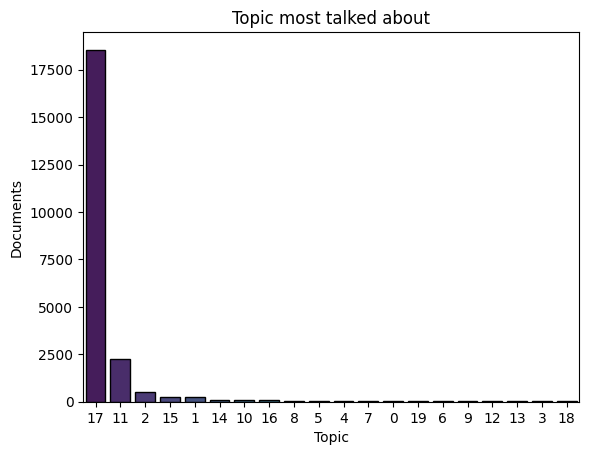

In [91]:
ax=sns.barplot(data=df_topic_counts,x='topic',y='num_documents',palette="viridis",edgecolor='k')
ax=plt.title('Topic most talked about')
ax=plt.ylabel('Documents')
ax=plt.xlabel('Topic')

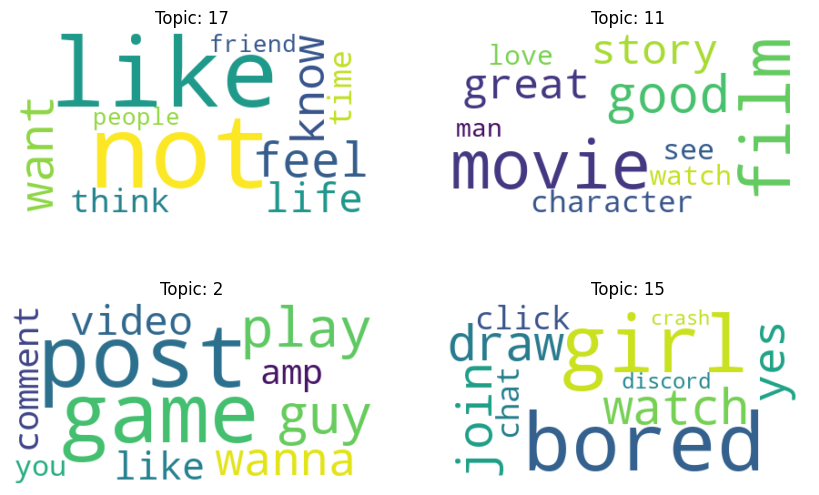

In [92]:

topiclist=[17,11,2,15]
multiplot_wordcloud_for_topics(topiclist, topic_word, vocab, rows=2, cols=2, max_words=10)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.3)

#### LDA sklearn using word level tf-idf 

In [93]:
%%time
# train a LDA Model
# here we are training on count vectors which will be equivlent to tf. We could also have used tf-idf 
lda_model = LatentDirichletAllocation(n_components = 20, learning_method = 'online', max_iter = 20,random_state=42)

X_topics_tfidf = lda_model.fit_transform(X_train_tfidf)
topic_word_tfidf = lda_model.components_ 
vocab_tfidf = tfidf_vect.get_feature_names_out()
X_test_lda_tfidf = lda_model.transform(X_test_tfidf)

CPU times: user 1min 54s, sys: 12.3 s, total: 2min 7s
Wall time: 41 s


In [94]:
print(np.shape(topic_word_tfidf))
print(np.shape(X_topics_tfidf))

(20, 5000)
(22380, 20)


In [95]:
# view the topic models
n_top_words = 10
topic_summaries = []
print('Group Top Words')
print('-----', '-'*80)
for i, topic_dist in enumerate(topic_word_tfidf):
    topic_words = np.array(vocab_tfidf)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    top_words = ' '.join(topic_words)
    topic_summaries.append(top_words)
    print('  %3d %s' % (i, top_words))

Group Top Words
----- --------------------------------------------------------------------------------
    0 you lmao karma christmas post cool day guy kinda pro
    1 not want feel like know life think people time friend
    2 text math milk test title host optional roll spain chill
    3 filler bored wanna pls talk play want idc bore hmu
    4 discord join server link crush wtf yay flirt confess jam
    5 hello mask weather survey question huh explore bread wear desert
    6 award rteenagers reddit anime free flair follower lol username epic
    7 youtube channel pog pronoun appreciation prolly spoon auto subscribe silver
    8 gay minecraft haha tryna lego upload chocolate mini image nostalgia
    9 chat comment dms need imma goodnight button uwu porn twitch
   10 horny cute hot cock yep selfie convert scale albert konf
   11 bro ppl omg bros pink fml pillow que subreddit cmon
   12 ampxb penis draw festival chinese china cheese golden disney mommy
   13 pizza buying generous gtpopl

In [96]:
# assuming you have trained a LDA model in sklearn and have a corpus of documents
topic_counts = {}
# doc_topic_dist = lda_model_sklearn.transform(corpus)
dominant_topic = [np.argmax(topic) for topic in X_topics_tfidf]

for topic in dominant_topic:
    if topic not in topic_counts:
        topic_counts[topic] = 1
    else:
        topic_counts[topic] += 1

# print the topic counts
df_topic_counts=pd.DataFrame(topic_counts.items(),columns=['topic','num_documents'])
# for topic, count in topic_counts.items():
#     print(f"Topic {topic}: {count} documents")
df_topic_counts=df_topic_counts.sort_values('num_documents',ascending=False).reset_index(drop=True)
df_topic_counts['topic']=df_topic_counts['topic'].astype(str)

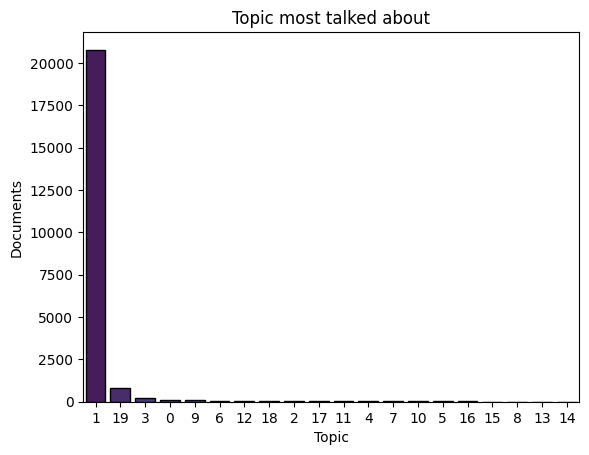

In [97]:
ax=sns.barplot(data=df_topic_counts,x='topic',y='num_documents',palette="viridis",edgecolor='k')
ax=plt.title('Topic most talked about')
ax=plt.ylabel('Documents')
ax=plt.xlabel('Topic')

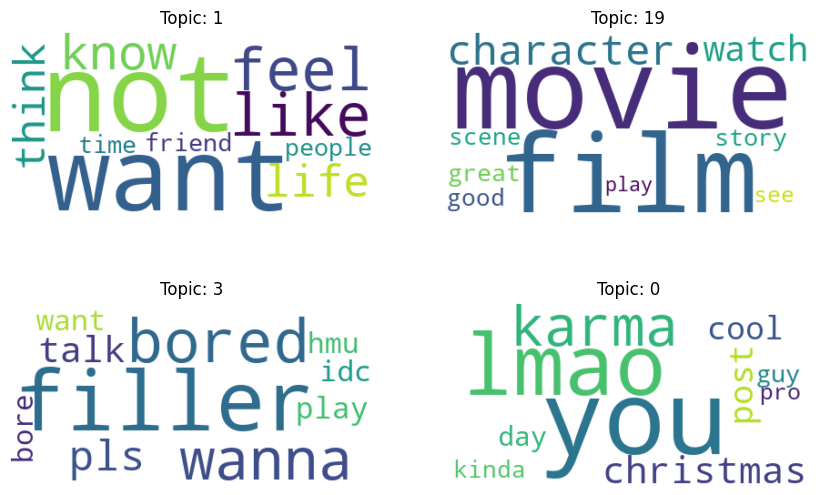

In [98]:
topiclist=[1,19,3,0]
multiplot_wordcloud_for_topics(topiclist, topic_word_tfidf, vocab_tfidf, rows=2, cols=2, max_words=10)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.3)

### LDA Get topic features from gensim

In [101]:
# Create a dictionary and corpus needed for topic modeling using gensim
id2word = gensim.corpora.Dictionary(X_train.apply(lambda x: x.split()))
corpus = [id2word.doc2bow(text) for text in X_train.apply(lambda x: x.split())]

In [102]:
# Converting list of documents (corpus) into Document Term Matrix using the dictionary 
# Note use the dict_ from the training corpus  not the test corpus

corpus_test = [id2word.doc2bow(text) for text in X_test.apply(lambda x: x.split())]

In [103]:
# Train the topic model using gensim's LDA algorithm
lda_model_gs = LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=20, 
                                            random_state=42,
                                            update_every=1,
                                            chunksize=100,
                                            passes=1,
                                            alpha='auto',
                                            per_word_topics=True)

In [104]:
# lda_model_gs.print_topics()
print(lda_model_gs.print_topics(num_topics=20, num_words=5))

[(0, '0.085*"favorite" + 0.071*"plot" + 0.060*"line" + 0.056*"book" + 0.042*"pick"'), (1, '0.078*"fine" + 0.068*"free" + 0.062*"crush" + 0.043*"yesterday" + 0.043*"cold"'), (2, '0.071*"want" + 0.066*"feel" + 0.033*"like" + 0.028*"try" + 0.027*"know"'), (3, '0.141*"exist" + 0.062*"sub" + 0.047*"earth" + 0.046*"park" + 0.034*"terrified"'), (4, '0.107*"lately" + 0.080*"blood" + 0.048*"animal" + 0.038*"weed" + 0.031*"blue"'), (5, '0.124*"help" + 0.079*"need" + 0.037*"redflag" + 0.037*"sorry" + 0.034*"tell"'), (6, '0.039*"shoulder" + 0.038*"personally" + 0.038*"awake" + 0.035*"contribute" + 0.031*"void"'), (7, '0.225*"play" + 0.164*"game" + 0.034*"quality" + 0.030*"copy" + 0.025*"natural"'), (8, '0.106*"video" + 0.091*"country" + 0.078*"music" + 0.066*"cool" + 0.041*"till"'), (9, '0.067*"dark" + 0.052*"wear" + 0.052*"appreciate" + 0.049*"upset" + 0.049*"society"'), (10, '0.098*"weird" + 0.094*"worthless" + 0.074*"forever" + 0.046*"goal" + 0.037*"crash"'), (11, '0.042*"life" + 0.036*"year" +

In [105]:
print('\nPerplexity: ', lda_model_gs.log_perplexity(corpus))


Perplexity:  -13.488427476213058


In [106]:
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(
   model=lda_model_gs, texts=corpus, dictionary=id2word, coherence='c_v'
)
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/Users/echanj/.local/share/virtualenvs/jupyter_stuff-JQ3hnF7h/lib/python3.7/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
/Users/echanj/.local/share/virtualenvs/jupyter_stuff-JQ3hnF7h/lib/python3.7/site-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))



Coherence Score:  nan


In [116]:
# coherence is NaN due to topic probabilitys having zero vlues   
for i in range(lda_model_gs.num_topics):
    print(lda_model_gs.show_topic(i))

[('favorite', 0.085314386), ('plot', 0.070780165), ('line', 0.060223762), ('book', 0.055559788), ('pick', 0.04179513), ('actual', 0.039408583), ('value', 0.031636897), ('business', 0.03161878), ('battle', 0.026384803), ('genre', 0.02522353)]
[('fine', 0.077702194), ('free', 0.06762279), ('crush', 0.06229953), ('yesterday', 0.043262716), ('cold', 0.043027114), ('dick', 0.039060067), ('record', 0.03816787), ('awkward', 0.026597278), ('gain', 0.021069542), ('forgive', 0.020681912)]
[('want', 0.07148099), ('feel', 0.06567231), ('like', 0.03260548), ('try', 0.02806182), ('know', 0.026954621), ('die', 0.020446336), ('fuck', 0.018466325), ('anymore', 0.016927592), ('kill', 0.015663732), ('hate', 0.015331451)]
[('exist', 0.14149246), ('sub', 0.06195643), ('earth', 0.04745882), ('park', 0.045531724), ('terrified', 0.0343631), ('america', 0.032641996), ('chase', 0.031168122), ('bridge', 0.027914122), ('racist', 0.019128585), ('eve', 0.016660891)]
[('lately', 0.10717083), ('blood', 0.079920605), 

In [117]:
# this is a way to strip out the raw topic distrbutions
topic_distributions = []
for doc_term in corpus:
    doc_topics = lda_model_gs.get_document_topics(doc_term, minimum_probability=0.0)
    topic_distributions.append([prob for _, prob in doc_topics])

In [118]:
# this is a way to strip out the raw topic distrbutions from the test data
# doc_term_matrix2 was created using only the training document dictionary 
# ldamodel  is trained on trasformed data  
topic_distributions_test = []
for doc_term in corpus_test:
    doc_topics = lda_model_gs.get_document_topics(doc_term, minimum_probability=0.0)
    topic_distributions_test.append([prob for _, prob in doc_topics])

In [119]:
print(np.shape(topic_distributions))
print(np.shape(topic_distributions_test))

(22380, 20)
(5595, 20)


In [120]:
np.sum(np.array(topic_distributions)[:5,:],axis=1)
X_topics_gensim=np.array(topic_distributions) 
X_topics_gensim_test=np.array(topic_distributions_test) 
print(np.shape(X_topics_gensim))
print(np.shape(X_topics_gensim_test))

(22380, 20)
(5595, 20)


In [121]:
print(lda_model_gs.get_document_topics(corpus[0], minimum_probability=0.0))
max(lda_model_gs.get_document_topics(corpus[0], minimum_probability=0.0), key=lambda x: x[1])[0]

[(0, 0.005904742), (1, 0.009204989), (2, 0.22576948), (3, 0.0028037932), (4, 0.00236544), (5, 0.046714064), (6, 0.0012780281), (7, 0.0025212772), (8, 0.005298354), (9, 0.0075977826), (10, 0.005585405), (11, 0.22149694), (12, 0.012744059), (13, 0.30546805), (14, 0.056592498), (15, 0.0020680085), (16, 0.006628499), (17, 0.0055638887), (18, 0.009197972), (19, 0.06519669)]


13

In [122]:
# assuming you have trained a LDA model in gensim and have a corpus of documents
topic_counts = {}
for doc in corpus:
    topic_dist = lda_model_gs.get_document_topics(doc)
    dominant_topic = max(topic_dist, key=lambda x: x[1])[0]
    if dominant_topic not in topic_counts:
        topic_counts[dominant_topic] = 1
    else:
        topic_counts[dominant_topic] += 1

        
# print the topic counts
df_topic_counts=pd.DataFrame(topic_counts.items(),columns=['topic','num_documents'])
# for topic, count in topic_counts.items():
#     print(f"Topic {topic}: {count} documents")
df_topic_counts=df_topic_counts.sort_values('num_documents',ascending=False).reset_index(drop=True)
df_topic_counts['topic']=df_topic_counts['topic'].astype(str)
# print the topic counts
# for topic, count in topic_counts.items():
#    print(f"Topic {topic}: {count} documents")

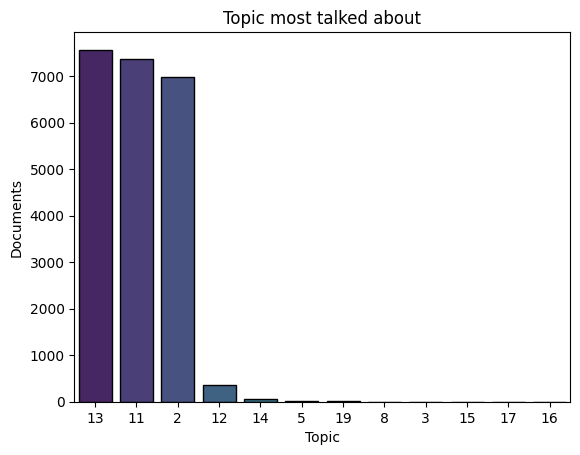

In [123]:
ax=sns.barplot(data=df_topic_counts,x='topic',y='num_documents',palette="viridis",edgecolor='k')
ax=plt.title('Topic most talked about')
ax=plt.ylabel('Documents')
ax=plt.xlabel('Topic')

In [199]:
def plot_wordclouds(topic_list, lda_topics, rows=2, cols=2):
    num_topics = len(topic_list)
    fig=plt.figure(figsize=(8, 8))
    # Get the top 10 words for each topic
    topic_words = []
    for topic in lda_topics:
        topic_words.append([word.split('*')[1].replace('"','').strip() for word in topic[1].split('+')])
    
    # Create a wordcloud for each topic
    for i in range(num_topics):

        plt.subplot(rows, cols, i+1)
        wordcloud = WordCloud(width=800, height=800,
                              background_color='white',
                              max_words=50).generate(' '.join(topic_words[i][:50]))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title('Topic {}'.format(topic_list[i]))
    plt.show()
# contour_width=3, contour_color='steelblue'

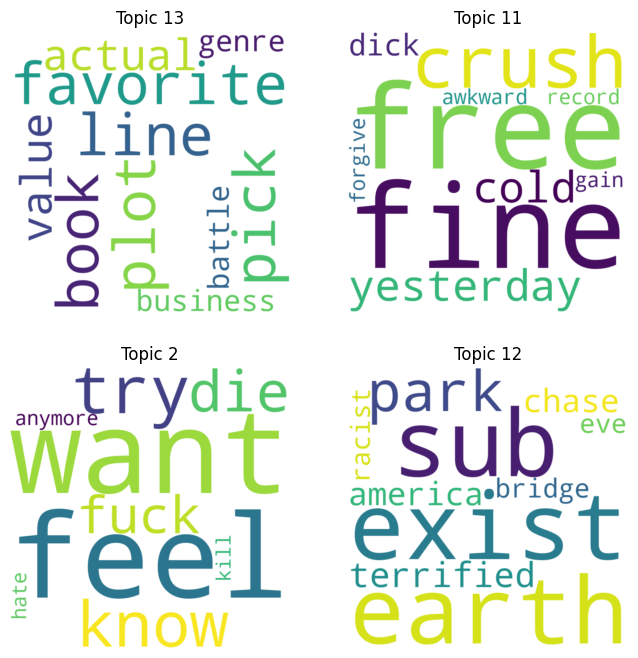

<Figure size 640x480 with 0 Axes>

In [200]:
topic_list = [13, 11, 2, 12]
lda_topics = lda_model_gs.print_topics(num_topics=20, num_words=10)

plot_wordclouds(topic_list, lda_topics, rows=2, cols=2)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.3,
                    hspace=0.2)

In [126]:
nytrain=y_train.reset_index(drop=True)
len(nytrain)
tddata = pd.DataFrame(np.array(topic_distributions))
tddata['labels']=nytrain
tddata_sorted=tddata.sort_values('labels')
tddata_sorted['labels']

0        0
12478    0
12484    0
12485    0
12486    0
        ..
13150    1
13151    1
13152    1
13155    1
14929    1
Name: labels, Length: 22380, dtype: int64

22380


/Users/echanj/.local/share/virtualenvs/jupyter_stuff-JQ3hnF7h/lib/python3.7/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


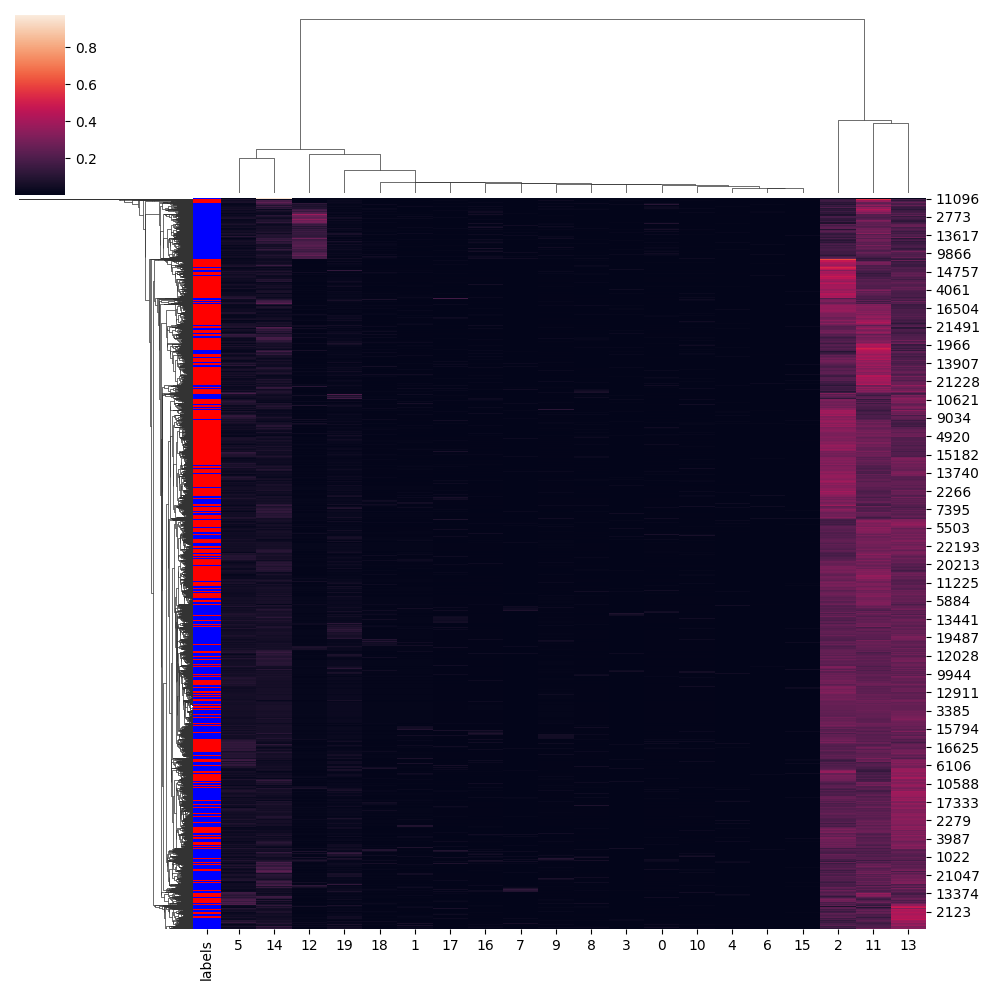

In [127]:
lut = dict(zip([1,0], "rb"))
row_colors = tddata['labels'].map(lut)
print(len(row_colors))
sns.clustermap(tddata.drop('labels',axis=1),row_cluster=True,col_cluster=True,row_colors=row_colors)

22380


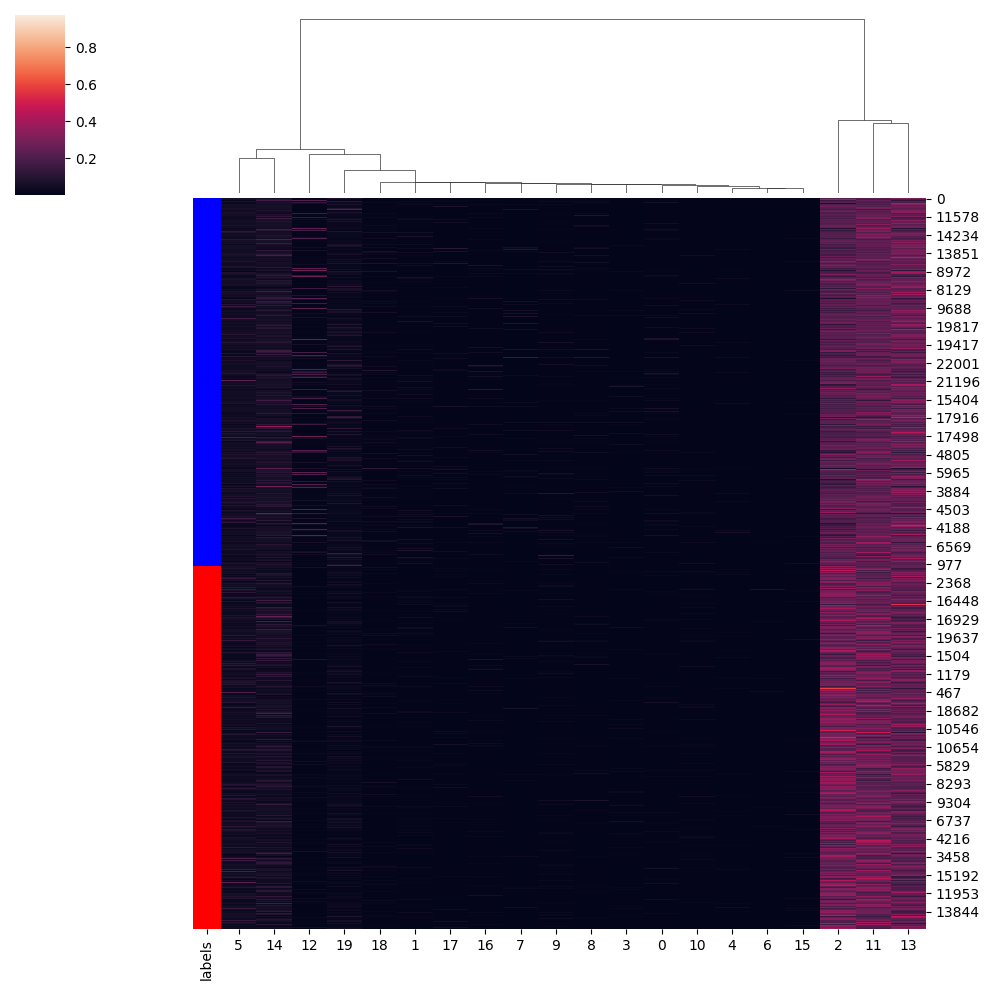

In [128]:
lut = dict(zip([1,0], "rb"))
row_colors = tddata_sorted['labels'].map(lut)
print(len(row_colors))
sns.clustermap(tddata_sorted.drop('labels',axis=1),row_cluster=False,col_cluster=True,row_colors=row_colors)

In [129]:
lda_model_gs.get_document_topics(corpus)[0]

[(2, 0.22577354),
 (5, 0.046714064),
 (11, 0.22149718),
 (12, 0.012744059),
 (13, 0.30546376),
 (14, 0.056592498),
 (19, 0.06519669)]

(22380, 12)


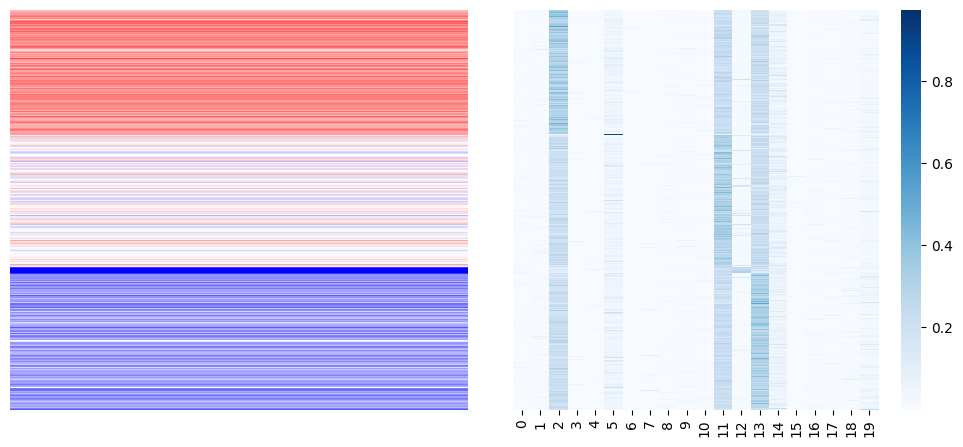

In [135]:


# input array of topic distributions from gensim
topic_distributions = lda_model_gs.get_document_topics(corpus, minimum_probability=0.0)

# get the topic with the highest probability for each document
max_topics = [max(t, key=lambda x: x[1])[0] for t in topic_distributions]

# sort the documents by their max topic
sort_order = np.argsort(max_topics)

# reorder the topic distribution array by the sort order
sorted_topic_distributions = [topic_distributions[i] for i in sort_order]

# create a DataFrame with the topic distributions for each document
df = pd.DataFrame([[prob for _, prob in t] for t in sorted_topic_distributions])

# reorder the columns of the DataFrame to place the strongest topic along the diagonal
# strongest_topic = df.idxmax(axis=1)
# df = df[df.columns.sort_values(key=lambda x: strongest_topic[x])]

nytrain=y_train.reset_index(drop=True).values

img = c_[nytrain[sort_order],nytrain[sort_order]]
for _ in range(10):
    img = c_[img,nytrain[sort_order]]
    
print(np.shape(img))
# reshape the column into a 2D array
# img = np.reshape(col, (len(col), 1))
my_cmap = plt.cm.get_cmap('bwr')  # blue is 0 'not depressed' and red is 1 'depressed'
# print(col)


# create a heatmap with the sorted topic distribution DataFrame

fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.heatmap(df, ax=axes[1], cmap='Blues', xticklabels=True, yticklabels=False)
# plot the column using imshow
axes[0].imshow(img,aspect='auto', cmap=my_cmap,vmin=0, vmax=1)
axes[0].axis("off")

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.1)


In [142]:
sum(np.isnan(nytrain))

0

In [155]:
# print(len(max_topics))#
# print(len(sort_order))
# print(max_topics)
# print(sort_order)
# np.sort(max_topics)

80
80
[17, 15, 6, 2, 10, 0, 11, 10, 13, 1, 11, 6, 14, 5, 8, 5, 1, 5, 7, 1, 17, 6, 18, 10, 11, 8, 0, 1, 19, 16, 16, 1, 15, 2, 10, 15, 1, 2, 6, 0, 15, 12, 19, 0, 14, 12, 0, 12, 9, 0, 7, 7, 19, 13, 14, 13, 19, 16, 6, 13, 7, 9, 15, 13, 1, 19, 11, 15, 5, 12, 11, 16, 9, 17, 14, 17, 17, 18, 15, 0]
[39 49 46 43 26 79  5 27 19  9 36 31 64 16 33 37  3 15 13 17 68  2 58 38
 21 11 51 50 18 60 25 14 61 72 48  4 34  7 23 66  6 70 10 24 47 41 69 45
  8 63 59 53 55 54 74 44 12 35 40 67  1 78 62 32 71 29 30 57 75 73 76  0
 20 22 77 56 52 28 65 42]


array([ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,
        5,  5,  5,  5,  6,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,  9,  9,
        9, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13, 13,
       13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 18, 18, 19, 19, 19, 19, 19])

## did not need the below functions

### Do some more typical fitting based on BOW 1and ti-dif  

In [143]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [144]:
## helper function

def train_model(classifier, feature_vector_train, label, feature_vector_valid):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)

    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)

    return accuracy_score(predictions, y_test)

In [145]:
# Keep the results in a dataframe
results = pd.DataFrame(columns = ['Count Vectors',
                                  'WordLevel TF-IDF',
                                  'N-Gram Vectors',
                                  'CharLevel Vectors',
                                  'Glove Vectors',
                                  'count vector LDA', 
                                  'TF-IDF LDA',
                                 'GENSIM LDA'])

### Naive Bayes Classifier

In [146]:
%%time
# Naive Bayes on Count Vectors
accuracy1 = train_model(MultinomialNB(), X_train_count, y_train, X_test_count)
print('NB, Count Vectors    : %.4f\n' % accuracy1)

NB, Count Vectors    : 0.8425

CPU times: user 15.7 ms, sys: 4.2 ms, total: 19.9 ms
Wall time: 18.3 ms


In [147]:
%%time
# Naive Bayes on Word Level TF IDF Vectors
accuracy2 = train_model(MultinomialNB(), X_train_tfidf, y_train, X_test_tfidf)
print('NB, WordLevel TF-IDF : %.4f\n' % accuracy2)

NB, WordLevel TF-IDF : 0.8867

CPU times: user 9.02 ms, sys: 2.09 ms, total: 11.1 ms
Wall time: 9.21 ms


In [148]:
%%time
# Naive Bayes on Ngram Level TF IDF Vectors
accuracy3 = train_model(MultinomialNB(), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('NB, N-Gram Vectors   : %.4f\n' % accuracy3)

NB, N-Gram Vectors   : 0.8533

CPU times: user 7.61 ms, sys: 2.53 ms, total: 10.1 ms
Wall time: 8.51 ms


In [149]:
%%time
# # Naive Bayes on Character Level TF IDF Vectors
accuracy4 = train_model(MultinomialNB(), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
print('NB, CharLevel Vectors: %.4f\n' % accuracy4)

NB, CharLevel Vectors: 0.8740

CPU times: user 59.6 ms, sys: 73.8 ms, total: 133 ms
Wall time: 132 ms


In [150]:
%%time
# # Naive Bayes on Glove vectors
accuracy5 = train_model(GaussianNB(), Xg_train, y_train, Xg_test)
print('GNB, Glove Vectors: %.4f\n' % accuracy5)

GNB, Glove Vectors: 0.8004

CPU times: user 70.6 ms, sys: 68.9 ms, total: 139 ms
Wall time: 185 ms


In [151]:
%%time
# # Naive Bayes on sklearn countvector LDA
accuracy_lda_skl = train_model(GaussianNB(), X_topics, y_train, X_test_lda)
print('GNB, count vector LDA sklearn  : %.4f\n' % accuracy_lda_skl)

GNB, count vector LDA sklearn  : 0.7787

CPU times: user 13.3 ms, sys: 5.63 ms, total: 18.9 ms
Wall time: 17.1 ms


In [152]:
%%time
# # Naive Bayes on on sklearn tf-idf vector LDA
accuracy_lda_skl_tfidf = train_model(GaussianNB(), X_topics_tfidf, y_train, X_test_lda_tfidf)
print('GNB, tf-idf LDA sklearn  : %.4f\n' % accuracy_lda_skl)

GNB, tf-idf LDA sklearn  : 0.7787

CPU times: user 11.8 ms, sys: 2.96 ms, total: 14.8 ms
Wall time: 12.8 ms


In [153]:
%%time
# Naive Bayes  on gensim LDA
accuracy_lda_gs = train_model(GaussianNB(), X_topics_gensim, y_train, X_topics_gensim_test)
print('GNB, LDA gensim: %.4f\n' % accuracy_lda_gs)

GNB, LDA gensim: 0.7008

CPU times: user 10 ms, sys: 2.28 ms, total: 12.3 ms
Wall time: 10.6 ms


In [154]:
results.loc['Naïve Bayes'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4,
    'Glove Vectors': accuracy5, 
    'count vector LDA': accuracy_lda_skl, 
    'TF-IDF LDA': accuracy_lda_skl_tfidf,
    'GENSIM LDA': accuracy_lda_gs
}

In [155]:
results

Count Vectors  WordLevel TF-IDF  N-Gram Vectors  \
Naïve Bayes       0.842538          0.886685        0.853262   

             CharLevel Vectors  Glove Vectors  count vector LDA  TF-IDF LDA  \
Naïve Bayes           0.873995       0.800357          0.778731    0.734227   

             GENSIM LDA  
Naïve Bayes    0.700804

### Linear Classifier

In [156]:
%%time
# Linear Classifier on Count Vectors
accuracy1 = train_model(LogisticRegression(solver = 'lbfgs', max_iter = 350), X_train_count, y_train, X_test_count)
print('LR, Count Vectors    : %.4f\n' % accuracy1)

LR, Count Vectors    : 0.9058

CPU times: user 22.1 s, sys: 4.59 s, total: 26.7 s
Wall time: 2.53 s


In [157]:
%%time
# Linear Classifier on Word Level TF IDF Vectors
accuracy2 = train_model(LogisticRegression(solver = 'lbfgs', max_iter = 100), X_train_tfidf, y_train, X_test_tfidf)
print('LR, WordLevel TF-IDF : %.4f\n' % accuracy2)

LR, WordLevel TF-IDF : 0.9146

CPU times: user 179 ms, sys: 7.48 ms, total: 187 ms
Wall time: 186 ms


In [158]:
%%time
# Linear Classifier on Ngram Level TF IDF Vectors
accuracy3 = train_model(LogisticRegression(solver = 'lbfgs', max_iter = 100), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('LR, N-Gram Vectors   : %.4f\n' % accuracy3)

LR, N-Gram Vectors   : 0.8615

CPU times: user 198 ms, sys: 3.65 ms, total: 201 ms
Wall time: 200 ms


In [159]:
%%time
# Linear Classifier on Character Level TF IDF Vectors
accuracy4 = train_model(LogisticRegression(solver = 'lbfgs', max_iter = 100), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
print('LR, CharLevel Vectors: %.4f\n' % accuracy4)

LR, CharLevel Vectors: 0.9180

CPU times: user 1.38 s, sys: 4.11 ms, total: 1.38 s
Wall time: 1.38 s


In [160]:
%%time
# # Linear Classifier on Glove vectors
accuracy5 = train_model(LogisticRegression(solver = 'lbfgs', max_iter = 1000), Xg_train, y_train, Xg_test)
print('LR, Glove Vectors: %.4f\n' % accuracy5)

LR, Glove Vectors: 0.8845

CPU times: user 26 s, sys: 1.31 s, total: 27.3 s
Wall time: 4.61 s


In [161]:
%%time
# # Linear Classifier  on sklearn countvector LDA
accuracy_lda_skl = train_model(LogisticRegression(solver = 'lbfgs', max_iter = 100), X_topics, y_train, X_test_lda)
print('LR, count vector LDA sklearn  : %.4f\n' % accuracy_lda_skl)

LR, count vector LDA sklearn  : 0.8132

CPU times: user 449 ms, sys: 70 ms, total: 519 ms
Wall time: 90.3 ms


In [162]:
%%time
# # Linear Classifier  on sklearn tf-idf vector LDA
accuracy_lda_skl_tfidf = train_model(LogisticRegression(solver = 'lbfgs', max_iter = 100), X_topics_tfidf, y_train, X_test_lda_tfidf)
print('LR, tf-idf LDA sklearn  : %.4f\n' % accuracy_lda_skl)

LR, tf-idf LDA sklearn  : 0.8132

CPU times: user 384 ms, sys: 53.7 ms, total: 437 ms
Wall time: 75.7 ms


In [163]:
%%time
# Linear Classifier on gensim LDA
accuracy_lda_gs = train_model(LogisticRegression(solver = 'lbfgs', max_iter = 100), X_topics_gensim, y_train, X_topics_gensim_test)
print('LR, LDA : %.4f\n' % accuracy_lda_gs)

LR, LDA : 0.7932

CPU times: user 461 ms, sys: 68.4 ms, total: 529 ms
Wall time: 92.9 ms


In [164]:
results.loc['Logistic Regression'] = {
     'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4,
    'Glove Vectors': accuracy5, 
    'count vector LDA': accuracy_lda_skl, 
    'TF-IDF LDA': accuracy_lda_skl_tfidf,
    'GENSIM LDA': accuracy_lda_gs}

In [165]:
results

Count Vectors  WordLevel TF-IDF  N-Gram Vectors  \
Naïve Bayes               0.842538          0.886685        0.853262   
Logistic Regression       0.905809          0.914567        0.861483   

                     CharLevel Vectors  Glove Vectors  count vector LDA  \
Naïve Bayes                   0.873995       0.800357          0.778731   
Logistic Regression           0.917962       0.884540          0.813226   

                     TF-IDF LDA  GENSIM LDA  
Naïve Bayes            0.734227    0.700804  
Logistic Regression    0.791242    0.793208

### Support Vector Machine

In [174]:
%%time
# Support Vector Machine on Count Vectors
accuracy1 = train_model(LinearSVC(max_iter = 20000), X_train_count, y_train, X_test_count)
print('SVM, Count Vectors    : %.4f\n' % accuracy1)

SVM, Count Vectors    : 0.8928

CPU times: user 2.51 s, sys: 7.12 ms, total: 2.52 s
Wall time: 2.52 s


In [175]:
%%time
# Support Vector Machine on Word Level TF IDF Vectors
accuracy2 = train_model(LinearSVC(max_iter = 20000), X_train_tfidf, y_train, X_test_tfidf)
print('SVM, WordLevel TF-IDF : %.4f\n' % accuracy2)

SVM, WordLevel TF-IDF : 0.9101

CPU times: user 116 ms, sys: 5.07 ms, total: 121 ms
Wall time: 119 ms


In [176]:
%%time
# Support Vector Machine on Ngram Level TF IDF Vectors
accuracy3 = train_model(LinearSVC(max_iter = 20000), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('SVM, N-Gram Vectors   : %.4f\n' % accuracy3)

SVM, N-Gram Vectors   : 0.8440

CPU times: user 73.9 ms, sys: 4.19 ms, total: 78.1 ms
Wall time: 76.7 ms


In [177]:
%%time
# Support Vector Machine on Character Level TF IDF Vectors
accuracy4 = train_model(LinearSVC(max_iter = 20000), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
print('SVM, CharLevel Vectors: %.4f\n' % accuracy4)

SVM, CharLevel Vectors: 0.9285

CPU times: user 598 ms, sys: 45.2 ms, total: 643 ms
Wall time: 642 ms


In [179]:
%%time
# Support Vector Machine on Glove vectors
# this might be too many dimensions and needs adjustment
accuracy5 = train_model(LinearSVC(max_iter = 2000), Xg_train, y_train, Xg_test)
print('SVM, Glove Vectors: %.4f\n' % accuracy5)

SVM, Glove Vectors: 0.8856

CPU times: user 29.6 s, sys: 51.4 ms, total: 29.6 s
Wall time: 29.6 s


/Users/echanj/.local/share/virtualenvs/jupyter_stuff-JQ3hnF7h/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [180]:
%%time
# Support Vector Machine  on sklearn countvector LDA
accuracy_lda_skl = train_model(LinearSVC(max_iter = 20000), X_topics, y_train, X_test_lda)
print('SVM, count vector LDA sklearn  : %.4f\n' % accuracy_lda_skl)

SVM, count vector LDA sklearn  : 0.8107

CPU times: user 168 ms, sys: 14.2 ms, total: 182 ms
Wall time: 176 ms


In [181]:
%%time
# Support Vector Machine  on sklearn tf-idf vector LDA
accuracy_lda_skl_tfidf = train_model(LinearSVC(max_iter = 20000), X_topics_tfidf, y_train, X_test_lda_tfidf)
print('SVM, tf-idf LDA sklearn  : %.4f\n' % accuracy_lda_skl)

SVM, tf-idf LDA sklearn  : 0.8107

CPU times: user 170 ms, sys: 3.61 ms, total: 174 ms
Wall time: 167 ms


In [182]:
%%time
# Support Vector Machine on gensim LDA
accuracy_lda_gs = train_model(LinearSVC(max_iter = 20000), X_topics_gensim, y_train, X_topics_gensim_test)
print('SVM, LDA : %.4f\n' % accuracy_lda_gs)

SVM, LDA : 0.7964

CPU times: user 145 ms, sys: 4.96 ms, total: 150 ms
Wall time: 143 ms


In [183]:
results.loc['Support Vector Machine'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4,
    'Glove Vectors': accuracy5, 
    'count vector LDA': accuracy_lda_skl, 
    'TF-IDF LDA': accuracy_lda_skl_tfidf,
    'GENSIM LDA': accuracy_lda_gs
}

In [184]:
results

Count Vectors  WordLevel TF-IDF  N-Gram Vectors  \
Naïve Bayes                  0.842538          0.886685        0.853262   
Logistic Regression          0.905809          0.914567        0.861483   
Support Vector Machine       0.892761          0.910098        0.843968   

                        CharLevel Vectors  Glove Vectors  count vector LDA  \
Naïve Bayes                      0.873995       0.800357          0.778731   
Logistic Regression              0.917962       0.884540          0.813226   
Support Vector Machine           0.928508       0.885612          0.810724   

                        TF-IDF LDA  GENSIM LDA  
Naïve Bayes               0.734227    0.700804  
Logistic Regression       0.791242    0.793208  
Support Vector Machine    0.781412    0.796425

### SGDclassifier

In [185]:


sgd_huber = SGDClassifier(
    max_iter=1000,
    tol=1e-3,
    alpha=20,
    loss='modified_huber',
    class_weight='balanced'
)

# scaler = StandardScaler()
# X_train_scale = scaler.fit_transform(X_train)
# sgd_huber.fit(X_train_scale, y_train)


In [186]:
%%time
# SGD huber on count vectors
accuracy1 = train_model(sgd_huber, X_train_count, y_train, X_test_count)
print('SGD, Count Vectors    : %.4f\n' % accuracy1)

SGD, Count Vectors    : 0.7088

CPU times: user 245 ms, sys: 40.7 ms, total: 286 ms
Wall time: 57.7 ms


In [187]:
%%time
# SGD huber  on Word Level TF IDF Vectors
accuracy2 = train_model(sgd_huber, X_train_tfidf, y_train, X_test_tfidf)
print('SGD, WordLevel TF-IDF : %.4f\n' % accuracy2)

SGD, WordLevel TF-IDF : 0.4854

CPU times: user 38 ms, sys: 1.6 ms, total: 39.6 ms
Wall time: 37.6 ms


In [188]:
%%time
# SGD huber  on Ngram Level TF IDF Vectors
accuracy3 = train_model(sgd_huber, X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('SGD, N-Gram Vectors   : %.4f\n' % accuracy3)

SGD, N-Gram Vectors   : 0.4854

CPU times: user 20.9 ms, sys: 1.37 ms, total: 22.2 ms
Wall time: 20.6 ms


In [189]:
%%time
# SGD huber  on Character Level TF IDF Vectors
accuracy4 = train_model(sgd_huber, X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
print('SGD, CharLevel Vectors: %.4f\n' % accuracy4)

SGD, CharLevel Vectors: 0.5146

CPU times: user 168 ms, sys: 1.86 ms, total: 169 ms
Wall time: 168 ms


In [190]:
%%time
# SGD huber  on Glove vectors
accuracy5 = train_model(sgd_huber, Xg_train, y_train, Xg_test)
print('SGD, Glove Vectors: %.4f\n' % accuracy5)

SGD, Glove Vectors: 0.8393

CPU times: user 192 ms, sys: 22.1 ms, total: 214 ms
Wall time: 202 ms


In [191]:
%%time
# SGD huber   on sklearn countvector LDA
accuracy_lda_skl = train_model(sgd_huber, X_topics, y_train, X_test_lda)
print('SGD, count vector LDA sklearn  : %.4f\n' % accuracy_lda_skl)

SGD, count vector LDA sklearn  : 0.5146

CPU times: user 58.9 ms, sys: 2.65 ms, total: 61.6 ms
Wall time: 55.4 ms


In [192]:
%%time
# SGD huber   on sklearn tf-idf vector LDA
accuracy_lda_skl_tfidf = train_model(sgd_huber, X_topics_tfidf, y_train, X_test_lda_tfidf)
print('SGD, tf-idf LDA sklearn  : %.4f\n' % accuracy_lda_skl)

SGD, tf-idf LDA sklearn  : 0.5146

CPU times: user 55.4 ms, sys: 2.14 ms, total: 57.6 ms
Wall time: 51.6 ms


In [193]:
%%time
# SGD huber on gensim LDA
accuracy_lda_gs = train_model(sgd_huber, X_topics_gensim, y_train, X_topics_gensim_test)
print('SGD, LDA : %.4f\n' % accuracy_lda_gs)

SGD, LDA : 0.4854

CPU times: user 57.8 ms, sys: 2.28 ms, total: 60.1 ms
Wall time: 53.5 ms


In [194]:
results.loc['SGD-Huber'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4,
     'Glove Vectors': accuracy5, 
    'count vector LDA': accuracy_lda_skl, 
    'TF-IDF LDA': accuracy_lda_skl_tfidf,
    'GENSIM LDA': accuracy_lda_gs
}

In [195]:
results

Count Vectors  WordLevel TF-IDF  N-Gram Vectors  \
Naïve Bayes                  0.842538          0.886685        0.853262   
Logistic Regression          0.905809          0.914567        0.861483   
Support Vector Machine       0.892761          0.910098        0.843968   
SGD-Huber                    0.708847          0.485433        0.485433   

                        CharLevel Vectors  Glove Vectors  count vector LDA  \
Naïve Bayes                      0.873995       0.800357          0.778731   
Logistic Regression              0.917962       0.884540          0.813226   
Support Vector Machine           0.928508       0.885612          0.810724   
SGD-Huber                        0.514567       0.839321          0.514567   

                        TF-IDF LDA  GENSIM LDA  
Naïve Bayes               0.734227    0.700804  
Logistic Regression       0.791242    0.793208  
Support Vector Machine    0.781412    0.796425  
SGD-Huber                 0.514567    0.485433

### it would have been better to show these results as a barplot

## pyLDAvis

In [201]:
# run this at the end 
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_gs, corpus, id2word)
vis

/Users/echanj/.local/share/virtualenvs/jupyter_stuff-JQ3hnF7h/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.406028 -0.034208       1        1  26.885586
13    -0.398496 -0.106411       2        1  24.227129
2     -0.384229 -0.147566       3        1  23.899156
14    -0.240285  0.191348       4        1   7.435496
5     -0.200527 -0.093705       5        1   4.895867
12    -0.135770  0.297423       6        1   3.735101
19    -0.021326  0.180139       7        1   2.488136
18     0.098687 -0.015864       8        1   0.873388
1      0.110203 -0.006799       9        1   0.787552
16     0.108967 -0.022793      10        1   0.735196
9      0.121758 -0.017873      11        1   0.683757
0      0.117732 -0.025427      12        1   0.659507
8      0.128957 -0.005776      13        1   0.544491
17     0.135722 -0.028114      14        1   0.483951
10     0.135579 -0.033889      15        1   0.476673
7      0.148772  0.011580      16        1   0.335077
3      0.157836 -0.034826      17        1   0.298439
4      0.162335 -0.035256      18        1   0.262491
15     0.175771 -0.035938      19        1   0.181867
6      0.184341 -0.036046      20        1   0.111136, topic_info=         Term          Freq         Total Category  logprob  loglift
2         not  26317.000000  26317.000000  Default  30.0000  30.0000
168      want  22028.000000  22028.000000  Default  29.0000  29.0000
97       help   7898.000000   7898.000000  Default  28.0000  28.0000
86       feel  22355.000000  22355.000000  Default  27.0000  27.0000
431      film   5570.000000   5570.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
3609  disease      0.019083      1.001521  Topic20 -11.1743   2.8417
3508    space      0.019083      1.001545  Topic20 -11.1743   2.8417
2119      far      0.019083      1.001637  Topic20 -11.1743   2.8416
2894    woman      0.019083      1.001620  Topic20 -11.1743   2.8416
47      sleep      0.019096   2747.414047  Topic20 -11.1736  -5.0745

[970 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1094      2  0.023201  absolutely
1094      5  0.970981  absolutely
1094      7  0.004640  absolutely
556       4  0.999387       abuse
1648     10  0.992400      accent
...     ...       ...         ...
932       1  0.196923         yes
932       2  0.802461         yes
172       9  0.997698   yesterday
933       8  0.998434         you
248      11  0.997239     youtube

[1205 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 14, 3, 15, 6, 13, 20, 19, 2, 17, 10, 1, 9, 18, 11, 8, 4, 5, 16, 7])

### note:   we are only ranking models based on accuracy. to dive infurth we might want to also calculate confusion matries, roc curve etc., since this is binary classifier. We can also get precision and recall. however data was reaonably balanced.

### Below is bonus codes for BERT model which we can investigate/enjoy when there is some spare time 

In [204]:
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix
from transformers import BertTokenizer, TFBertForSequenceClassification

In [206]:
df=pd.read_csv('mental_heath_EJC_big_words.csv')
df=df.dropna() # remove rows with null values
df.isnull().value_counts()

Unnamed: 0  text   label
False       False  False    27975
dtype: int64

In [207]:
# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Tokenize the text data and convert it to input features for BERT
input_ids = []
attention_masks = []
for text in df['text']:
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens=True,
                        max_length=64,
                        pad_to_max_length=True,
                        return_attention_mask=True,
                        return_tensors='tf',
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/echanj/.local/share/virtualenvs/jupyter_stuff-JQ3hnF7h/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2360: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
2023-04-30 13:37:50.137894: I tensorflow/core/pla

In [208]:
input_ids = tf.concat(input_ids, axis=0)
attention_masks = tf.concat(attention_masks, axis=0)
labels = tf.constant(df['label'].values, dtype=tf.int32)

# Split the data into training and validation sets
dataset = tf.data.Dataset.from_tensor_slices((input_ids, attention_masks, labels))
dataset = dataset.shuffle(1000).batch(32).repeat(4)
train_size = int(0.8 * len(df))
val_size = len(df) - train_size
train_dataset = dataset.take(train_size // 32)
val_dataset = dataset.skip(train_size // 32)

In [ ]:
# Load the pre-trained BERT model and add a classification layer on top
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Train the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
history = model.fit(train_dataset, epochs=4, validation_data=val_dataset)

# Evaluate the model
test_input_ids = tf.constant(tokenizer.encode(df['text'].tolist(), add_special_tokens=True, max_length=64, pad_to_max_length=True))
test_attention_masks = tf.math.not_equal(test_input_ids, 0)
test_preds = model.predict([test_input_ids, test_attention_masks])
test_preds = tf.argmax(test_preds.logits, axis=1)
test_labels = tf.constant(df['label'].values, dtype=tf.int32)
test_acc = accuracy_score(test_labels, test_preds)
test_cm = confusion_matrix(test_labels, test_preds)
print('Test accuracy:', test_acc)
print('Test confusion matrix:', test_cm)